In [160]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10683.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10736.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10489.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10512.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10975.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10064.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10281.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10384.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10986.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10870.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10786.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10268.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10760.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_10759.jpg
/kaggle/input/waste-classification-data/DATASET/TEST/R/R_11008

In [161]:
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("Is GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow Version: 2.17.1
Is GPU Available: []


In [162]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


In [163]:
train_path = "/kaggle/input/waste-classification-data/DATASET/TRAIN"
test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"

In [164]:
# Importing Libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import plot_model
from glob import glob

In [165]:
# Visualization
from cv2 import cvtColor
x_data = []
y_data = []
for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array = cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array)
        y_data.append(category.split("/")[-1])
data = pd.DataFrame({'image': x_data, 'label': y_data})

100%|██████████| 12565/12565 [00:23<00:00, 526.92it/s]


In [166]:
data.shape

(22564, 2)

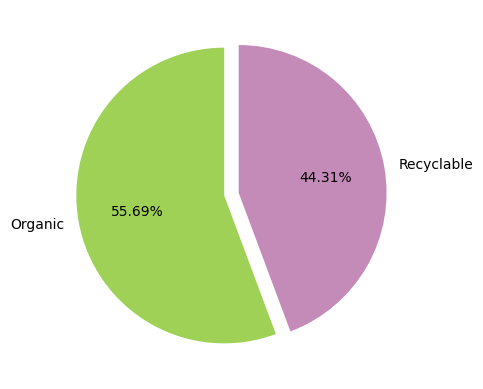

In [167]:
colors = ['#a0d157', '#c48bb8']
plt.pie(data.label.value_counts(), labels=['Organic', 'Recyclable'], autopct='%0.2f%%',
        colors=colors, startangle=90, explode=[0.05, 0.05])
plt.show()

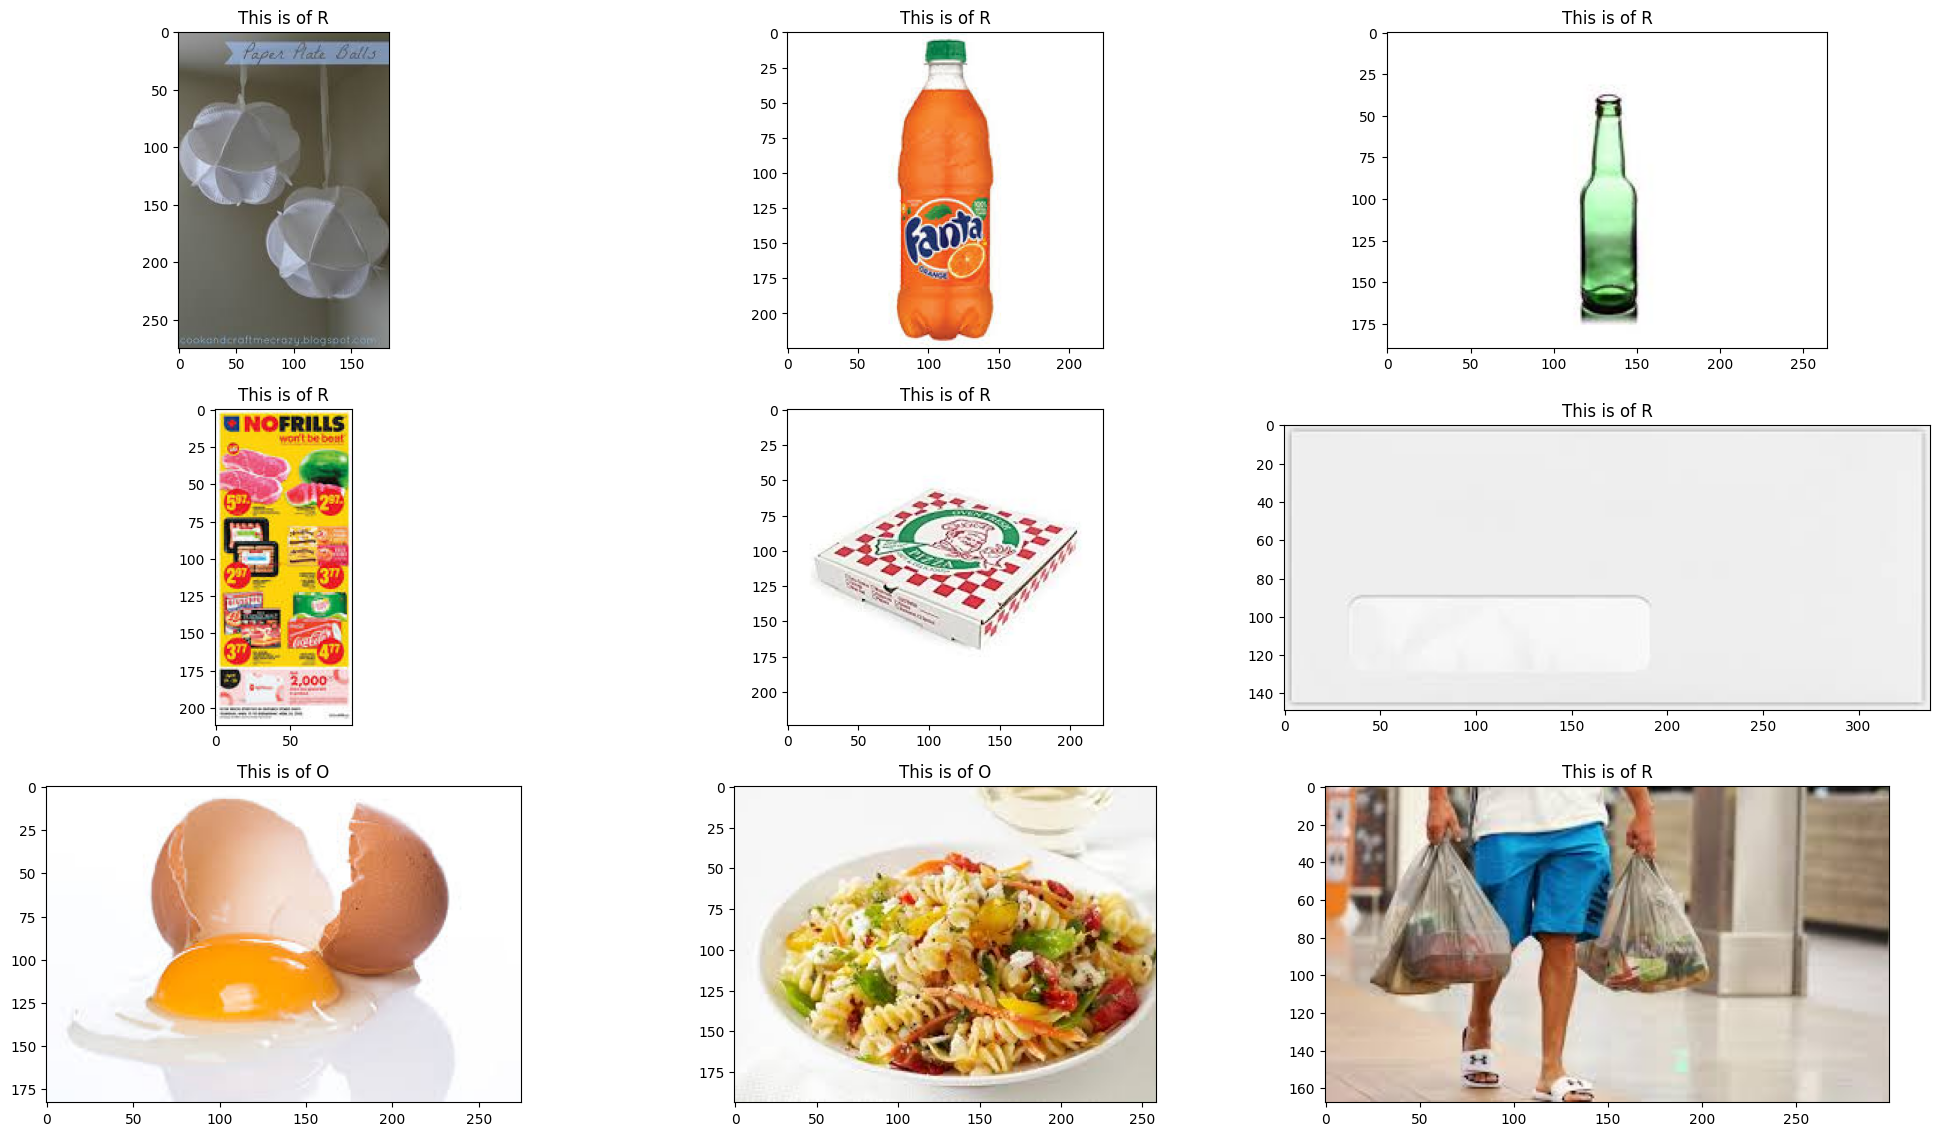

In [168]:
plt.figure(figsize=(20, 15))
for i in range(9):
    plt.subplot(4, 3,(i%12)+1)
    index = np.random.randint(15000)
    plt.title('This is of {0}'.format(data.label[index]))
    plt.imshow(data.image[index])
    plt.tight_layout()

In [169]:
# Data Augmentation for better generalization
"""
We use `ImageDataGenerator` to apply transformations such as:
- Rotation, width/height shift, shear, zoom, and flipping
- Rescaling pixel values to [0,1]
- Splitting training data into training (80%) and validation (20%)
"""
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [170]:
# Load training and validation sets

#### We create training and validation generators using the augmented dataset.
#### - `target_size`: Resize images to 150x150 pixels
#### - `batch_size`: Set batch size to 32 for optimal training speed
#### - `class_mode`: Categorical classification for multiple classes
#### - `subset`: 'training' for training set and 'validation' for validation set


In [171]:
# Load training and validation data
"""
Generate training and validation datasets using augmentation.
Target size: 150x150 pixels, batch size: 32, class mode: categorical.
"""
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 18052 images belonging to 2 classes.
Found 4512 images belonging to 2 classes.


In [172]:
#building a CNN model

def build_model():
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        BatchNormalization(),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(len(train_generator.class_indices), activation='softmax')
    ])
    return model

In [173]:
# Compile the CNN model

### Use Adam optimizer with a learning rate of 0.0001 for smooth training.
### Loss function: Categorical Crossentropy, suitable for multi-class classification.
### Metric: Accuracy.


In [200]:
# Compile the CNN model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [175]:
# Display Model Summary

### View the architecture and parameter count of the compiled CNN model.

In [201]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_13 (Flatten)                 │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,586 (72.61 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [177]:
# Implement early stopping and checkpointing

### - **EarlyStopping**: Stops training when validation loss stops improving.
### - **ModelCheckpoint**: Saves the best model during training.

In [202]:

#If you want to train your model for 50 epochs and track the training and validation metrics, your code is already set up correctly. The key parts are:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks: Early stopping and model checkpointing
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# Train the model for up to 50 epochs
steps_per_epoch = len(train_generator)  # Full pass through data
validation_steps = len(validation_generator)  # Full pass for validation

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=10,  # Number of epochs
    callbacks=callbacks
)

Epoch 1/50
 47/565 ━━━━━━━━━━━━━━━━━━━━ 9:30 1s/step - accuracy: 0.7294 - loss: 1.5784

KeyboardInterrupt: 

In [ ]:
# Train the CNN model

### Train the model using 50 epochs and the augmented dataset.
### Monitor validation accuracy to prevent overfitting.


In [ ]:
# Save the trained model
### Store the final trained model for future inference.

In [192]:
# Save the trained model

model.save("Waste-Classification-CNN-Model.h5")

In [ ]:
# Plot training history

### Visualize training and validation performance using Matplotlib.
### - Accuracy curve shows model improvement.
### - Loss curve indicates model convergence.

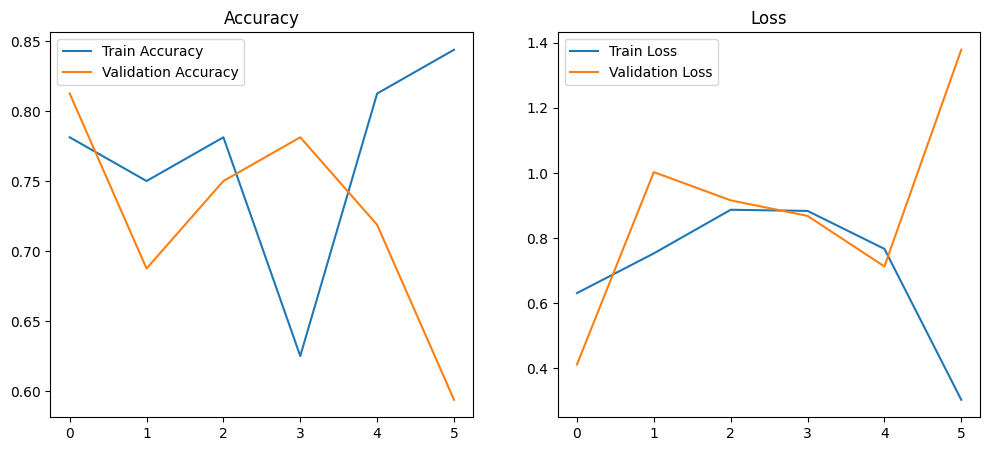

In [194]:
# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [ ]:
# Load the Trained Model

#### Now that our model is trained and saved, we load it back to perform predictions on new images.

In [193]:
# Load the Trained Model

from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model("Waste-Classification-CNN-Model.h5")

# Display the model architecture again to verify loading
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_33 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 74, 74, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 17, 17, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,588 (72.62 MB)

 Trainable params: 19,035,138 (72.61 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
# Prepare Test Data

#### - Define the path to the test dataset.
#### - Create an image generator for rescaling.
#### - Load test images in a format similar to the training dataset.

In [195]:
# Prepare Test Data

test_path = "/kaggle/input/waste-classification-data/DATASET/TEST"

# Rescale test images to match training data
test_datagen = ImageDataGenerator(rescale=1./255)

# Load test dataset with similar preprocessing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Do not shuffle so that labels remain aligned
)

Found 2513 images belonging to 2 classes.


In [ ]:
# Evaluate Model Performance on Test Data

#### We check how well our model generalizes by testing it on unseen data.

In [196]:
# Evaluate model accuracy on test set
test_loss, test_accuracy = model.evaluate(test_generator)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 254ms/step - accuracy: 0.8694 - loss: 0.5418
Test Accuracy: 82.37%
Test Loss: 0.6482


In [ ]:
# Make Predictions on Test Images

#### We will predict classes for test images and compare them with true labels.

In [197]:
# Make Predictions on Test Images

import numpy as np

# Get predictions (probabilities)
predictions = model.predict(test_generator)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get actual class labels from test generator
actual_classes = test_generator.classes

# Get class labels (to map indices back to names)
class_labels = list(test_generator.class_indices.keys())

# Print sample predictions
print("Predicted Classes:", [class_labels[i] for i in predicted_classes[:10]])
print("Actual Classes:", [class_labels[i] for i in actual_classes[:10]])

79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step
Predicted Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Actual Classes: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [ ]:
# Visualize Predictions

#### We randomly select some test images and display them with predicted labels.

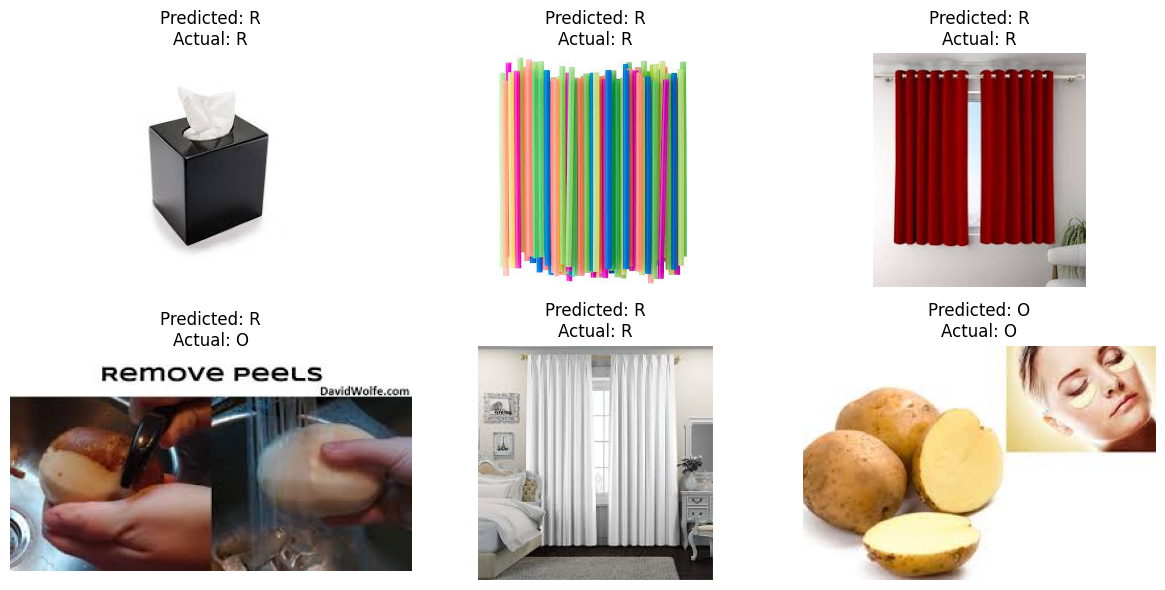

In [203]:
"""
# Visualize Some Test Images with Predictions
We randomly select some test images and display them with predicted labels.
"""
import matplotlib.pyplot as plt

# Get file names for test images
test_image_paths = test_generator.filepaths

# Select random indices
random_indices = np.random.choice(len(test_image_paths), 6, replace=False)

plt.figure(figsize=(12, 6))

for i, idx in enumerate(random_indices):
    img = cv2.imread(test_image_paths[idx])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display

    # Get predicted label
    predicted_label = class_labels[predicted_classes[idx]]
    actual_label = class_labels[actual_classes[idx]]

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Classification Report & Confusion Matrix

#### This helps analyze model performance per class.

Classification Report:

              precision    recall  f1-score   support

           O       0.84      0.85      0.84      1401
           R       0.81      0.79      0.80      1112

    accuracy                           0.82      2513
   macro avg       0.82      0.82      0.82      2513
weighted avg       0.82      0.82      0.82      2513



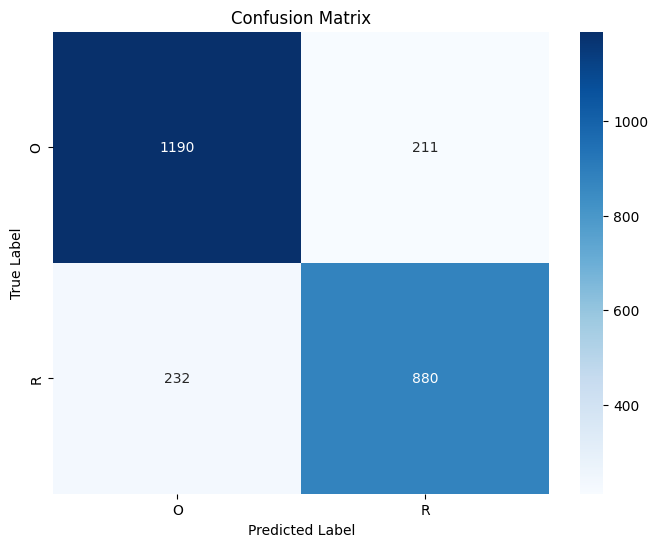

In [204]:
# Generate Classification Report and Confusion Matrix

from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:\n")
print(classification_report(actual_classes, predicted_classes, target_names=class_labels))

# Generate and plot confusion matrix
import seaborn as sns

cm = confusion_matrix(actual_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()